In [1]:
import os,sys
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import functions as fun

In [2]:
mods = fun.models()
scens = ['rcp45','rcp85']

In [3]:
with xr.open_dataset('../rawdata/rsl_85_2090.nc') as ds:
    lon = ds['x'].values
    lat = ds['y'].values
    slr_md = ds['slr_md'].values

(llon,llat) = np.meshgrid(lon,lat)
radius = 6371.
grid = 1.
area = radius**2 * (np.deg2rad(llon+grid/2) -np.deg2rad(llon-grid/2)) * (np.sin(np.deg2rad((llat+grid/2)))-np.sin(np.deg2rad((llat-grid/2))))

area[np.isnan(slr_md)] = np.nan
totarea = np.nansum(area)
print(totarea)

359949600.0


In [4]:
gmsl = np.zeros((len(mods),len(scens),95))
for s,scen in enumerate(scens):
    for m,model in enumerate(mods):
        
        #Add steric expansion    
        with xr.open_dataset(f'../data/steric/{model}_{scen}.nc') as ds:
            if s*m==0:
                time = ds['time'].values                
            gmsl[m,s,:] = ds['SLR'].values
        #Add glacier
        with xr.open_dataset(f'../data/glacier/{model}_{scen}.nc') as ds:
            gmsl[m,s,:] += ds['SLR'].values
        #Add Gsmb
        with xr.open_dataset(f'../data/Gsmb/{model}_{scen}.nc') as ds:
            gmsl[m,s,:] += ds['SLR'].values
        #Add Asmb
        with xr.open_dataset(f'../data/Asmb/{model}_{scen}.nc') as ds:
            gmsl[m,s,:] += ds['SLR'].values         
        #Add Adyn
        with xr.open_dataset(f'../data/Adyn/{model}_{scen}.nc') as ds:
            gmsl[m,s,:] += ds['SLR'].values

In [5]:
srocc = np.zeros((len(scens),94))
for s,scen in enumerate(scens):
    with xr.open_dataset(f'../rawdata/rsl_ts_{scen}.nc') as ds:
        slr = ds['slr_md'].values
        stime = ds['time'].values
        srocc[s,:] = 100.*np.nansum(np.nansum(slr*area[np.newaxis,:,:],axis=2),axis=1)/totarea

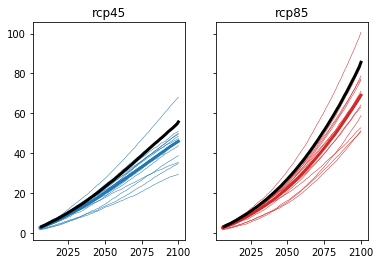

In [6]:
cols = ['tab:blue','tab:red']
fig,ax = plt.subplots(1,2,sharey=True)
for s,scen in enumerate(scens):
    for m,model in enumerate(mods):
        ax[s].plot(time,gmsl[m,s,:],lw=.5,c=cols[s])
    ax[s].plot(time,np.nanmean(gmsl[:,s,:],axis=0),lw=3,c=cols[s])
    ax[s].plot(stime,srocc[s,:],lw=3,c='k')
    ax[s].set_title(scen)

plt.savefig(f'../figures/gmsl.png',dpi=200)
plt.show()
plt.close()

In [7]:
gmsl2 = xr.DataArray(gmsl,dims=('model','scen','time'),coords={'model':mods,'scen':scens,'time':time})
ds = xr.Dataset({'gmsl':gmsl2})
ds.to_netcdf(f'../data/gmsl.nc')
ds.close()